In [1]:
import tensorflow as tf
import keras_tuner
import numpy as np


import pandas as pd
import openpyxl # Needed for reading excel
import pathlib

import decomposition
import models


2023-03-06 22:48:45.476217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
keras_tuner.__version__

'1.3.0'

In [3]:
tf.config.list_logical_devices()

2023-03-06 22:48:47.388466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-06 22:48:47.402113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-06 22:48:47.402342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-06 22:48:47.404047: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [4]:

cwd = pathlib.Path.cwd()

code_directory = cwd.parents[1]

bas_directory = code_directory / "notebooks" / "Bas"
gonem_directory = code_directory / "notebooks" / "Gonem"
# data_file = bas_directory / "cadeautjevoorGonemenLiza.xlsx"
data_file = gonem_directory / "MAIZE_FILTERED_2023-03-03_02-09-43.xlsx"
data_file



PosixPath('/code/notebooks/Gonem/MAIZE_FILTERED_2023-03-03_02-09-43.xlsx')

In [5]:
df = pd.read_excel(data_file, header=[0, 1], index_col=0)
df.describe()

AVG_TAVG                                                  \
PARTNER_Labels      Brazil      France     Germany     Hungary     Ukraine   
count           216.000000  216.000000  216.000000  216.000000  216.000000   
mean            238.206918  125.114033  104.384242  115.973956   96.108236   
std              24.001732   55.369823   64.922860   79.169353   89.890743   
min             146.692308   20.168095  -29.860742  -50.419892  -98.247057   
25%             228.163849   76.846499   48.831657   42.336756   16.897382   
50%             245.982781  121.139616  104.070270  120.209032   91.978710   
75%             254.598759  177.539390  163.029371  188.865269  182.982542   
max             276.134483  231.747995  229.864177  242.571429  239.800437   

               Corn Price Futures    MAX_TMAX                          \
PARTNER_Labels             Global      Brazil      France     Germany   
count                  214.000000  216.000000  216.000000  216.000000   
mean                   449.422897  345.882606  225.040629  218.882100   
std                    151.626084   24.225703   67.041674   80.903955   
min                    201.750000  282.000000  107.622222   36.388889   
25%                    356.500000  330.875000  163.036330  140.235830   
50%                    390.125000  345.000000  227.637049  227.176471   
75%                    562.312500  360.275000  284.274194  286.593137   
max                    818.250000  401.000000  362.382979  371.823529   

                            ... renewable_energy_consumption_perc_of_total  \
PARTNER_Labels     Hungary  ...                                     Brazil   
count           216.000000  ...                                 216.000000   
mean            237.624460  ...                                  45.991111   
std              86.148150  ...                                   1.903827   
min              43.666667  ...                                  41.710000   
25%             160.791667  ...                                  44.935417   
50%             242.500000  ...                                  46.735000   
75%             316.100000  ...                                  47.570000   
max             392.500000  ...                                  48.920000   

                                                                \
PARTNER_Labels      France     Germany     Hungary     Ukraine   
count           216.000000  216.000000  216.000000  216.000000   
mean             12.908264   13.671829   13.305579    4.565440   
std               2.276759    2.858289    2.676401    2.141226   
min               8.520000    7.280000    7.290000    1.270000   
25%              11.185000   11.146458   12.850625    2.810000   
50%              13.292500   14.003750   13.640000    3.499583   
75%              15.350000   16.579375   15.367083    7.147500   
max              15.530000   17.170000   17.180000    7.440000   

               unemployment_total                                      \
PARTNER_Labels             Brazil      France     Germany     Hungary   
count                  216.000000  216.000000  216.000000  216.000000   
mean                    10.153681    8.959583    5.569259    6.953935   
std                      2.296630    0.869592    2.214765    2.710982   
min                      6.760000    7.390000    3.140000    3.420000   
25%                      8.230833    8.068333    3.625000    4.050000   
50%                      9.553333    9.036250    4.990417    7.327500   
75%                     12.496042    9.789167    7.371042    9.500000   
max                     13.700000   10.350000   11.170000   11.170000   

                            
PARTNER_Labels     Ukraine  
count           216.000000  
mean              8.377477  
std               1.107168  
min               6.350000  
25%               7.492500  
50%               8.538750  
75%               9.317500  
max               9.830000  

[8 rows x 63 columns]

In [6]:
label_columns = ['price']
label_columns = df.columns[df.columns.get_level_values(0).isin(label_columns)].tolist()
label_columns

[('price', 'Brazil'),
 ('price', 'France'),
 ('price', 'Germany'),
 ('price', 'Global'),
 ('price', 'Hungary'),
 ('price', 'Ukraine')]

In [7]:
stl = decomposition.STLDecomposer(labels=label_columns, period=12)
log = decomposition.Logger(labels=label_columns)
std = decomposition.Standardizer()
mms = decomposition.MinMaxScaler()

preproc = decomposition.Processor().add(log).add(std).add(stl)

In [8]:
from windower import WindowGenerator

width = 24
label_width = 6
shift = 6

w = WindowGenerator(input_width=width, label_width=label_width, shift=shift, data=df, 
                    # train_begin=0, train_end=.9, val_begin=None, val_end=.96,
                    train_begin=0, train_end=.96, val_begin=None, val_end=None,
                    # train_begin=0, train_end=.5, val_begin=None, val_end=.8,
                    test_begin=None, test_end=.996, connect=True, remove_labels=True, label_columns=label_columns)
w.preprocess(preproc)
w

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29]
Label column name(s): [('price', 'Brazil'), ('price', 'France'), ('price', 'Germany'), ('price', 'Global'), ('price', 'Hungary'), ('price', 'Ukraine')]

In [9]:
w.train_df.tail(5)

price_trend price_seasonal price_residual price_trend  \
                 Brazil         Brazil         Brazil      France   
TIME_PERIOD                                                         
2021-11-01     0.743382       2.263731       0.204131    1.438160   
2021-12-01     0.714017      -0.224472      -0.377570    1.367648   
2022-01-01     0.681681       0.283744      -0.015838    1.292036   
2022-02-01     0.646431       0.448532      -0.034575    1.211759   
2022-03-01     0.608361       0.045353      -0.498172    1.127247   

            price_seasonal price_residual price_trend price_seasonal  \
                    France         France     Germany        Germany   
TIME_PERIOD                                                            
2021-11-01       -0.400818       0.065866    1.312617      -0.159450   
2021-12-01        0.555246      -0.739782    1.388919       0.007252   
2022-01-01       -0.178856       0.221264    1.465471       0.088056   
2022-02-01        0.485849      -0.426413    1.542429       0.062710   
2022-03-01        0.413221      -0.191965    1.619972       0.193871   

            price_residual price_trend  ... unemployment_total            \
                   Germany      Global  ...             France   Germany   
TIME_PERIOD                             ...                                
2021-11-01       -0.168582    1.930093  ...          -1.339159 -0.938878   
2021-12-01       -0.433435    2.018705  ...          -1.339159 -0.938878   
2022-01-01       -0.000102    2.105400  ...          -1.339159 -0.938878   
2022-02-01        0.116764    2.190221  ...          -1.339159 -0.938878   
2022-03-01        0.232212    2.273232  ...          -1.339159 -0.938878   

                                   price                                \
              Hungary  Ukraine    Brazil    France   Germany    Global   
TIME_PERIOD                                                              
2021-11-01  -1.122596  1.39341  3.211244  1.103208  0.984585  1.614126   
2021-12-01  -1.122596  1.39341  0.111976  1.183113  0.962737  1.882830   
2022-01-01  -1.122596  1.39341  0.949587  1.334444  1.553425  1.794491   
2022-02-01  -1.122596  1.39341  1.060388  1.271195  1.721903  2.165919   
2022-03-01  -1.122596  1.39341  0.155542  1.348502  2.046054  2.268144   

                                 
              Hungary   Ukraine  
TIME_PERIOD                      
2021-11-01   2.353540  0.980424  
2021-12-01   0.948267  1.669260  
2022-01-01   1.946410  1.251746  
2022-02-01   1.881186  1.750171  
2022-03-01   1.755316  1.869880  

[5 rows x 81 columns]

In [10]:
# all(w.train_df == w.val_df)
w.val_df.head(5)

price_trend price_seasonal price_residual price_trend  \
                 Brazil         Brazil         Brazil      France   
TIME_PERIOD                                                         
2005-01-01    -0.872494      -0.041742       0.392870   -1.930756   
2005-02-01    -0.811643      -0.165682       0.455959   -1.890029   
2005-03-01    -0.749210       0.308480      -0.044819   -1.849543   
2005-04-01    -0.685712       0.507370      -0.411442   -1.809131   
2005-05-01    -0.621746       0.530670      -0.349692   -1.768649   

            price_seasonal price_residual price_trend price_seasonal  \
                    France         France     Germany        Germany   
TIME_PERIOD                                                            
2005-01-01        0.251932      -0.107168   -2.301868      -0.037881   
2005-02-01        0.250296      -0.098591   -2.263232       0.066132   
2005-03-01       -0.041458       0.141450   -2.224361       0.214828   
2005-04-01       -0.115748      -0.043321   -2.185342       0.051712   
2005-05-01        0.003189       0.003183   -2.146182       0.088519   

            price_residual price_trend  ... unemployment_total            \
                   Germany      Global  ...             France   Germany   
TIME_PERIOD                             ...                                
2005-01-01        0.349868   -2.209592  ...          -0.148683  2.481470   
2005-02-01       -0.217500   -2.162935  ...          -0.153546  2.446966   
2005-03-01       -0.039487   -2.116322  ...          -0.158409  2.412463   
2005-04-01       -0.244985   -2.069642  ...          -0.163272  2.377959   
2005-05-01       -0.061929   -2.022788  ...          -0.168135  2.343456   

                                    price                                \
              Hungary   Ukraine    Brazil    France   Germany    Global   
TIME_PERIOD                                                               
2005-01-01   0.040680 -1.042821 -0.521366 -1.785991 -1.989881 -1.937839   
2005-02-01   0.049942 -1.071167 -0.521366 -1.738325 -2.414601 -2.100740   
2005-03-01   0.059204 -1.099513 -0.485550 -1.749550 -2.049020 -1.980676   
2005-04-01   0.068465 -1.127859 -0.589783 -1.968201 -2.378616 -2.210023   
2005-05-01   0.077727 -1.156205 -0.440768 -1.762277 -2.119592 -1.939840   

                                 
              Hungary   Ukraine  
TIME_PERIOD                      
2005-01-01  -1.078649  0.184703  
2005-02-01  -1.150978  0.012096  
2005-03-01  -1.209392  0.311921  
2005-04-01  -1.174462 -0.058310  
2005-05-01  -0.978474  0.470985  

[5 rows x 81 columns]

In [11]:
w.val_df.tail(5)

price_trend price_seasonal price_residual price_trend  \
                 Brazil         Brazil         Brazil      France   
TIME_PERIOD                                                         
2021-11-01     0.743382       2.263731       0.204131    1.438160   
2021-12-01     0.714017      -0.224472      -0.377570    1.367648   
2022-01-01     0.681681       0.283744      -0.015838    1.292036   
2022-02-01     0.646431       0.448532      -0.034575    1.211759   
2022-03-01     0.608361       0.045353      -0.498172    1.127247   

            price_seasonal price_residual price_trend price_seasonal  \
                    France         France     Germany        Germany   
TIME_PERIOD                                                            
2021-11-01       -0.400818       0.065866    1.312617      -0.159450   
2021-12-01        0.555246      -0.739782    1.388919       0.007252   
2022-01-01       -0.178856       0.221264    1.465471       0.088056   
2022-02-01        0.485849      -0.426413    1.542429       0.062710   
2022-03-01        0.413221      -0.191965    1.619972       0.193871   

            price_residual price_trend  ... unemployment_total            \
                   Germany      Global  ...             France   Germany   
TIME_PERIOD                             ...                                
2021-11-01       -0.168582    1.930093  ...          -1.339159 -0.938878   
2021-12-01       -0.433435    2.018705  ...          -1.339159 -0.938878   
2022-01-01       -0.000102    2.105400  ...          -1.339159 -0.938878   
2022-02-01        0.116764    2.190221  ...          -1.339159 -0.938878   
2022-03-01        0.232212    2.273232  ...          -1.339159 -0.938878   

                                   price                                \
              Hungary  Ukraine    Brazil    France   Germany    Global   
TIME_PERIOD                                                              
2021-11-01  -1.122596  1.39341  3.211244  1.103208  0.984585  1.614126   
2021-12-01  -1.122596  1.39341  0.111976  1.183113  0.962737  1.882830   
2022-01-01  -1.122596  1.39341  0.949587  1.334444  1.553425  1.794491   
2022-02-01  -1.122596  1.39341  1.060388  1.271195  1.721903  2.165919   
2022-03-01  -1.122596  1.39341  0.155542  1.348502  2.046054  2.268144   

                                 
              Hungary   Ukraine  
TIME_PERIOD                      
2021-11-01   2.353540  0.980424  
2021-12-01   0.948267  1.669260  
2022-01-01   1.946410  1.251746  
2022-02-01   1.881186  1.750171  
2022-03-01   1.755316  1.869880  

[5 rows x 81 columns]

In [12]:
w.test_df.head(5)

price_trend price_seasonal price_residual price_trend  \
                 Brazil         Brazil         Brazil      France   
TIME_PERIOD                                                         
2019-11-01    -2.284424       5.615983      -1.346680   -3.927608   
2019-12-01    -2.019760       1.587221      -0.065293   -3.367075   
2020-01-01    -1.761420       1.121053       0.080116   -2.824567   
2020-02-01    -1.509218       0.946377       0.085132   -2.299245   
2020-03-01    -1.262950       0.927161      -0.094060   -1.790426   

            price_seasonal price_residual price_trend price_seasonal  \
                    France         France     Germany        Germany   
TIME_PERIOD                                                            
2019-11-01        8.440670      -4.810330   -2.867105       8.301322   
2019-12-01        5.698624       0.564990   -2.446661       3.381425   
2020-01-01        2.433876       0.474607   -2.046863       2.067053   
2020-02-01        2.368273       0.034068   -1.666433       2.108566   
2020-03-01        1.579361       0.252582   -1.304000       1.421820   

            price_residual price_trend  ... unemployment_total            \
                   Germany      Global  ...             France   Germany   
TIME_PERIOD                             ...                                
2019-11-01       -5.257405   -4.495158  ...          -1.086280 -0.862370   
2019-12-01        0.128260   -3.919598  ...          -1.125184 -0.835368   
2020-01-01        0.203159   -3.366563  ...          -1.164089 -0.808365   
2020-02-01        0.347253   -2.834681  ...          -1.178678 -0.819241   
2020-03-01        0.546051   -2.322627  ...          -1.193267 -0.830117   

                                    price                                \
              Hungary   Ukraine    Brazil    France   Germany    Global   
TIME_PERIOD                                                               
2019-11-01  -1.099751  0.873988  1.984879 -0.297268  0.176812 -0.233763   
2019-12-01  -1.074127  0.972816 -0.497831  2.896538  1.063024  0.046399   
2020-01-01  -1.048502  1.071644 -0.560252  0.083916  0.223349 -0.162847   
2020-02-01  -1.054677  1.098458 -0.477709  0.103096  0.789385 -0.095393   
2020-03-01  -1.060851  1.125272 -0.429849  0.041517  0.663871  0.132499   

                                 
              Hungary   Ukraine  
TIME_PERIOD                      
2019-11-01   0.109866 -0.888247  
2019-12-01  -0.321027 -0.834174  
2020-01-01   2.754658 -0.815125  
2020-02-01   0.244221 -0.724015  
2020-03-01   0.155470 -0.503040  

[5 rows x 81 columns]

In [13]:
label_std = decomposition.Standardizer(mean=std.mean[w.label_columns], std=std.std[w.label_columns])
label_log = decomposition.Logger(label_indices=range(len(w.label_columns)))
# label_mms = decomposition.MinMaxScaler(min=mms.min[w.label_columns], max=mms.max[w.label_columns])
postproc = decomposition.Processor().add(label_std).add(label_log)
w.add_label_postprocess(postproc)

In [14]:
for example_inputs, example_labels in w.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    output_features = example_labels.shape[-1]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Inputs shape (batch, time, features): (32, 24, 75)
Labels shape (batch, time, features): (32, 6, 6)


In [15]:

@tf.function
def closs(x, y, a=-1):
    return (x - y)**2 + (tf.sign(x-y)+a)**6

In [16]:
def build_ARF(hp):
    lstm_units = hp.Int("lstm_units", min_value=32, max_value=512, step=32)
    lstm_layers = hp.Int("lstm_layers", min_value=0, max_value=10)
    prediction_units = hp.Int("prediction_units", min_value=32, max_value=512, step=32)
    prediction_layers = hp.Int("prediction_layers", min_value=0, max_value=10)
    feature_units = hp.Int("feature_units", min_value=32, max_value=512, step=32)
    feature_layers = hp.Int("feature_layers", min_value=0, max_value=10)
    
    heads = hp.Int("heads", min_value=1, max_value=16)
    dropout = hp.Float("dropout", min_value=0, max_value=1)
    key_dim = hp.Int('key_dim', min_value=16, max_value=128, step=16)
    
    l1 = hp.Float("l1", min_value=1e-7, max_value=1e-1, sampling="log")
    l2 = hp.Float("l2", min_value=1e-7, max_value=1e-1, sampling="log")
    kernel_regularizer = tf.keras.regularizers.L1L2(l1=l1, l2=l2)

    model = models.AutoregressiveFeedback(out_steps=label_width, number_of_features=output_features, lstm_units=lstm_units, lstm_layers=lstm_layers,
                                   prediction_units=prediction_units, prediction_layers=prediction_layers, feature_units=feature_units,
                                   feature_layers=feature_layers, key_dim=key_dim, heads=heads, dropout=dropout, kernel_regularizer=kernel_regularizer)
    learning_rate = hp.Float("learning_rate", min_value=1e-7, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse', 
        metrics=['mae', 'mse', 'mape', closs]
        )

    return model

In [17]:
def build_SS(hp):
    lstm_units = hp.Int("lstm_units", min_value=32, max_value=512, step=32)
    lstm_layers = hp.Int("lstm_layers", min_value=0, max_value=10)
    dense_units = hp.Int("dense_units", min_value=32, max_value=512, step=32)
    dense_layers = hp.Int("dense_layers", min_value=0, max_value=10)
    

    heads = hp.Int("heads", min_value=1, max_value=16)
    dropout = hp.Float("dropout", min_value=0, max_value=1)
    key_dim = hp.Int('key_dim', min_value=16, max_value=128, step=16)
    
    l1 = hp.Float("l1", min_value=1e-7, max_value=1e-1, sampling="log")
    l2 = hp.Float("l2", min_value=1e-7, max_value=1e-1, sampling="log")
    kernel_regularizer = tf.keras.regularizers.L1L2(l1=l1, l2=l2)
    
    model = models.SingleShot(out_steps=label_width, number_of_features=output_features, lstm_units=lstm_units, lstm_layers=lstm_layers, dense_units=dense_units, dense_layers=dense_layers, key_dim=key_dim, heads=heads, dropout=dropout, kernel_regularizer=kernel_regularizer)

    learning_rate = hp.Float("learning_rate", min_value=1e-7, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse', 
        metrics=['mae', 'mse', 'mape']
        )

    return model

In [18]:
def build_ED(hp):
    encoder_units = hp.Int("encoder_units", min_value=32, max_value=512, step=32)
    encoder_layers = hp.Int("encoder_layers", min_value=0, max_value=10)
    decoder_units = hp.Int("decoder_units", min_value=32, max_value=512, step=32)
    decoder_layers = hp.Int("decoder_layers", min_value=0, max_value=10)
    dense_units = hp.Int("dense_units", min_value=32, max_value=512, step=32)
    dense_layers = hp.Int("dense_layers", min_value=0, max_value=10)

    heads = hp.Int("heads", min_value=1, max_value=16)
    dropout = hp.Float("dropout", min_value=0, max_value=1)
    key_dim = hp.Int('key_dim', min_value=16, max_value=128, step=16)
    
    l1 = hp.Float("l1", min_value=1e-7, max_value=1e-1, sampling="log")
    l2 = hp.Float("l2", min_value=1e-7, max_value=1e-1, sampling="log")
    kernel_regularizer = tf.keras.regularizers.L1L2(l1=l1, l2=l2)

    model = models.EncoderDecoder(out_steps=label_width, number_of_features=output_features, encoder_units=encoder_units, encoder_layers=encoder_layers,
                           decoder_units=decoder_units, decoder_layers=decoder_layers, dense_units=dense_units,
                           dense_layers=dense_layers, key_dim=key_dim, heads=heads, dropout=dropout, kernel_regularizer=kernel_regularizer)

    learning_rate = hp.Float("learning_rate", min_value=1e-7, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse', 
        metrics=['mae', 'mse', 'mape']
        )

    return model

In [19]:

tuner_arf = keras_tuner.Hyperband(
    hypermodel=build_ARF,
    objective="val_mse",
    max_epochs=200,
    factor=3,
    hyperband_iterations=1,
    executions_per_trial=3,
    seed=2023,
    max_retries_per_trial=10,
    max_consecutive_failed_trials=10,
    overwrite=False,
    directory=gonem_directory/'hp',
    project_name="ARF",
)

INFO:tensorflow:Reloading Tuner from /code/notebooks/Gonem/hp/ARF/tuner0.json


In [20]:
tuner_ss = keras_tuner.Hyperband(
    hypermodel=build_SS,
    objective="val_mse",
    max_epochs=200,
    factor=3,
    hyperband_iterations=1,
    executions_per_trial=3,
    seed=2023,
    max_retries_per_trial=10,
    max_consecutive_failed_trials=10,
    overwrite=False,
    directory=gonem_directory/'hp',
    project_name="SS",
)

In [21]:
tuner_ed = keras_tuner.Hyperband(
    hypermodel=build_ED,
    objective="val_mse",
    max_epochs=200,
    factor=3,
    hyperband_iterations=1,
    executions_per_trial=3,
    seed=2023,
    max_retries_per_trial=10,
    max_consecutive_failed_trials=10,
    overwrite=False,
    directory=gonem_directory/'hp',
    project_name="ED",
)

In [ ]:
tuner_arf.search(w.train, validation_data=w.val, verbose=2)

Trial 41 Complete [00h 00m 31s]
val_mse: 0.8967564304669698

Best val_mse So Far: 0.7946456074714661
Total elapsed time: 00h 21m 09s

Search: Running Trial #42

Value             |Best Value So Far |Hyperparameter
320               |352               |lstm_units
10                |10                |lstm_layers
128               |288               |prediction_units
4                 |4                 |prediction_layers
480               |128               |feature_units
5                 |2                 |feature_layers
5                 |10                |heads
0.33963           |0.28089           |dropout
16                |48                |key_dim
0.00056644        |1.016e-06         |l1
5.9592e-06        |1.5653e-07        |l2
0.004086          |9.988e-05         |learning_rate
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tu

In [ ]:
tuner_ss.search(w.train, validation_data=w.val, verbose=2)

In [ ]:
tuner_ed.search(w.train, validation_data=w.val, verbose=2)

In [139]:
checkpoint_path = gonem_directory / 'hp' /'best_models'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_closs', verbose=0, save_best_only=True, save_weights_only=True)

In [140]:
# m_arf = tuner_arf.get_best_models(num_models=1)[0]
best_hps = tuner_arf.get_best_hyperparameters()[0]
print(best_hps.values)
# m_arf = tuner_arf.hypermodel.build(best_hps)

# m_arf.fit(w.train, epochs=25, validation_data=w.val, callbacks=[checkpoint])

{'lstm_units': 384, 'lstm_layers': 3, 'prediction_units': 512, 'prediction_layers': 5, 'feature_units': 352, 'feature_layers': 3, 'heads': 6, 'dropout': 0.1114966175710339, 'key_dim': 128, 'learning_rate': 0.00018055176622686154, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 4, 'tuner/round': 0}


In [144]:
model = models.AutoregressiveFeedback(out_steps=label_width, number_of_features=output_features, lstm_units=384, lstm_layers=3,
                                   prediction_units=512, prediction_layers=5, feature_units=352,
                                   feature_layers=3, key_dim=128, heads=6, dropout=0.11, kernel_regularizer='l1_l2')
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss=closs, 
    metrics=['mae', 'mse', 'mape', closs]
    )
model.fit(w.train, epochs=100, validation_data=w.val, callbacks=[checkpoint])

Epoch 1/100
6/6 [==============================] - 10s 523ms/step - loss: 592.0263 - mae: 0.6817 - mse: 0.8820 - mape: 109.8724 - closs: 33.4746 - val_loss: 551.0333 - val_mae: 1.4405 - val_mse: 2.6770 - val_mape: 115.0577 - val_closs: 6.2325
Epoch 2/100
6/6 [==============================] - 2s 402ms/step - loss: 573.0790 - mae: 0.6473 - mse: 0.7968 - mape: 126.2633 - closs: 35.5227 - val_loss: 531.9117 - val_mae: 1.3285 - val_mse: 2.3210 - val_mape: 133.1543 - val_closs: 7.7911
Epoch 3/100
6/6 [==============================] - 2s 333ms/step - loss: 553.5770 - mae: 0.6433 - mse: 0.7698 - mape: 163.3076 - closs: 36.5409 - val_loss: 511.6730 - val_mae: 1.2260 - val_mse: 2.0357 - val_mape: 155.0368 - val_closs: 7.7793
Epoch 4/100
6/6 [==============================] - 2s 396ms/step - loss: 533.6571 - mae: 0.6404 - mse: 0.7541 - mape: 195.0961 - closs: 36.6975 - val_loss: 493.4834 - val_mae: 1.1580 - val_mse: 1.8631 - val_mape: 159.0180 - val_closs: 9.3845
Epoch 5/100
6/6 [==============

In [146]:
# m_arf.load_weights(checkpoint_path)
model.load_weights(checkpoint_path)
model.evaluate(w.test)

1/1 [==============================] - 0s 193ms/step - loss: 661.5616 - mae: 3.6749 - mse: 113.8719 - mape: 99.1079 - closs: 116.7608


[661.5615844726562,
 3.6749236583709717,
 113.87186431884766,
 99.1078872680664,
 116.76075744628906]

('price', 'Brazil')


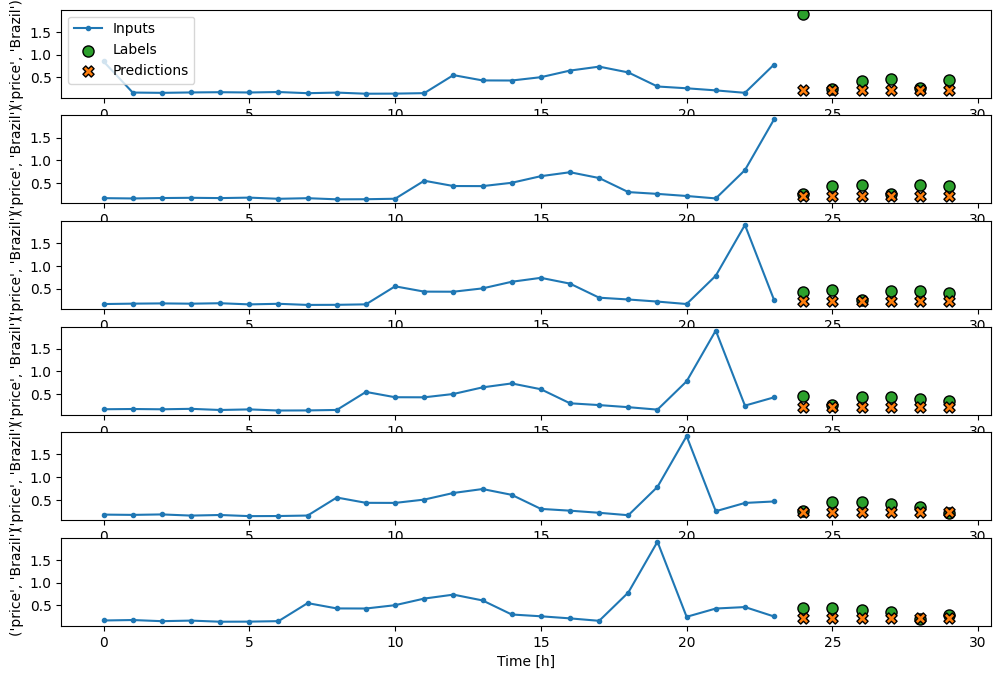

('price', 'France')


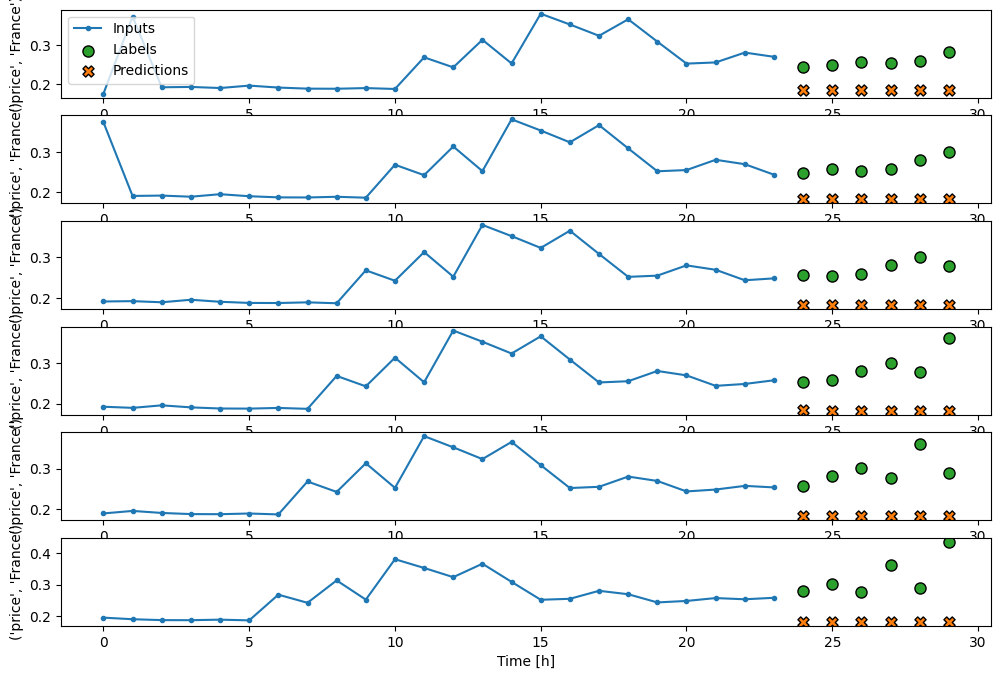

('price', 'Germany')


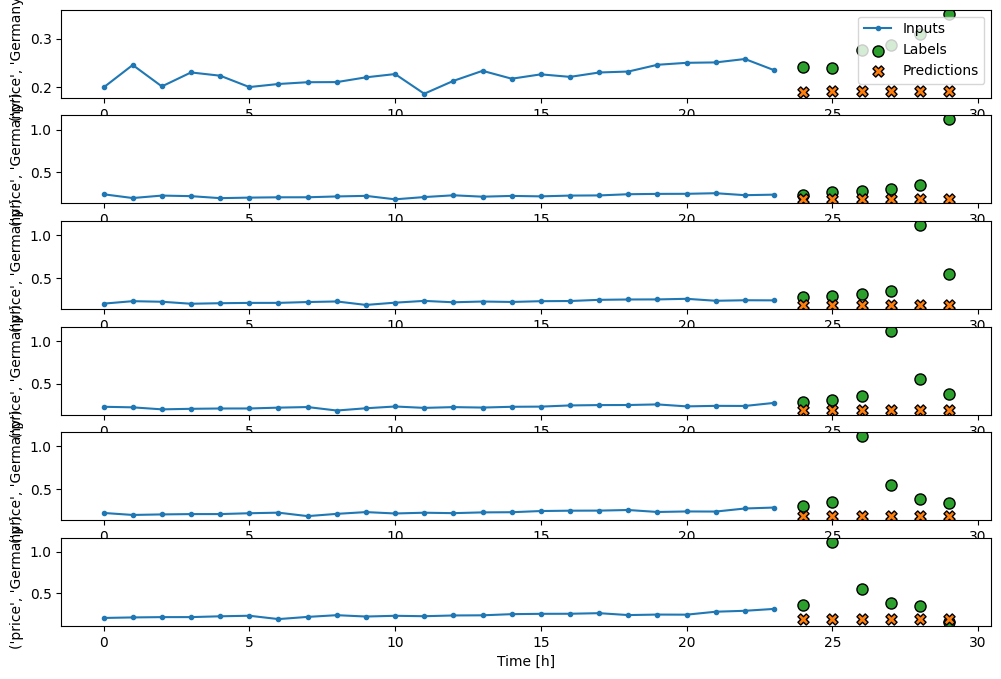

('price', 'Global')


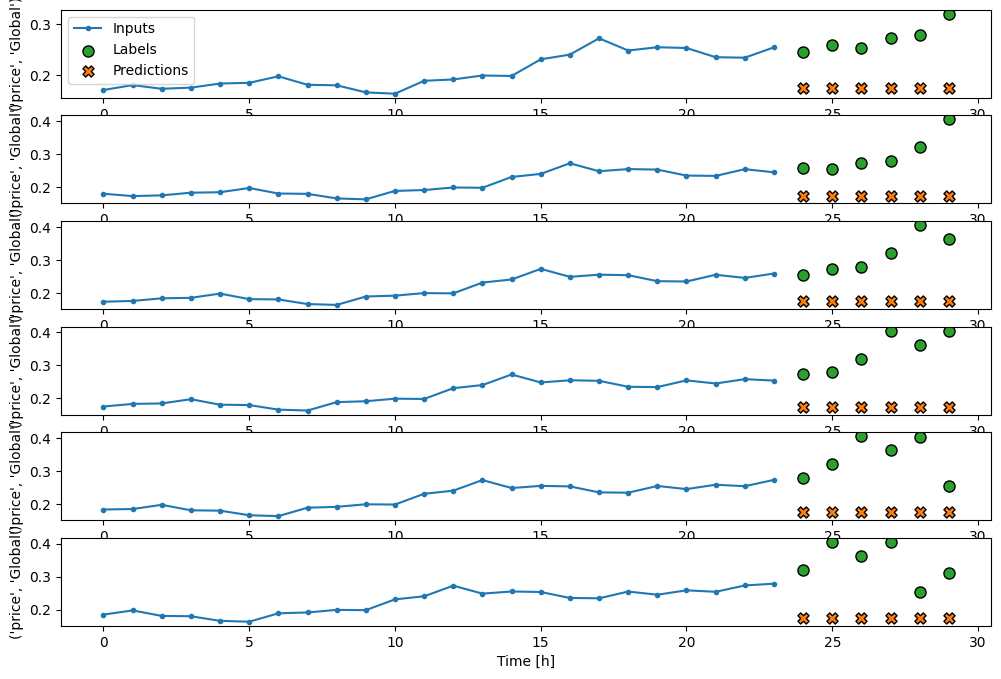

('price', 'Hungary')


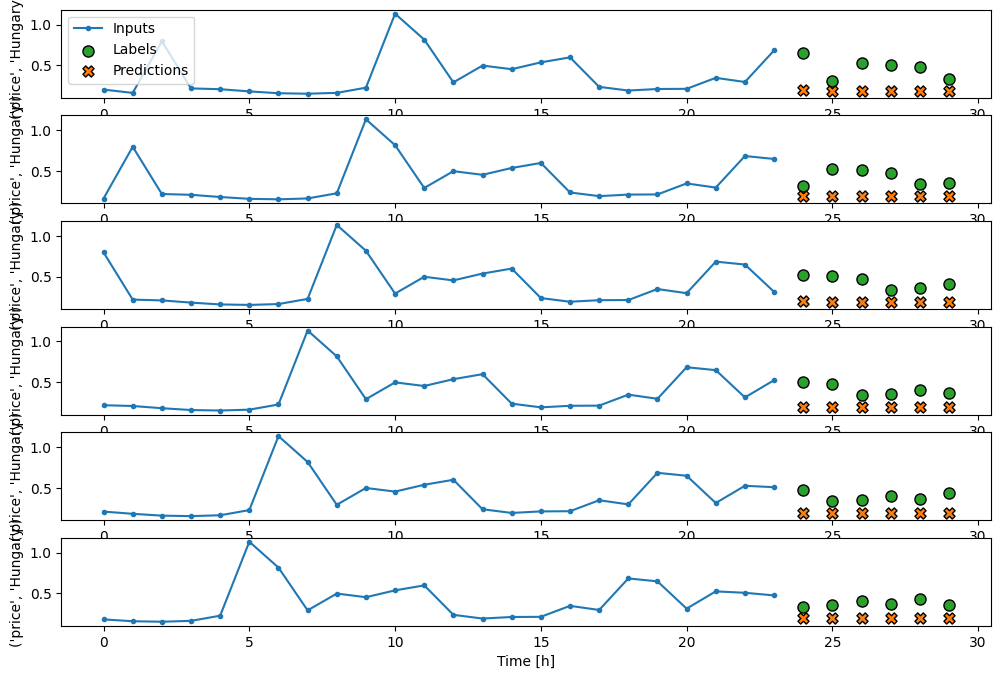

('price', 'Ukraine')


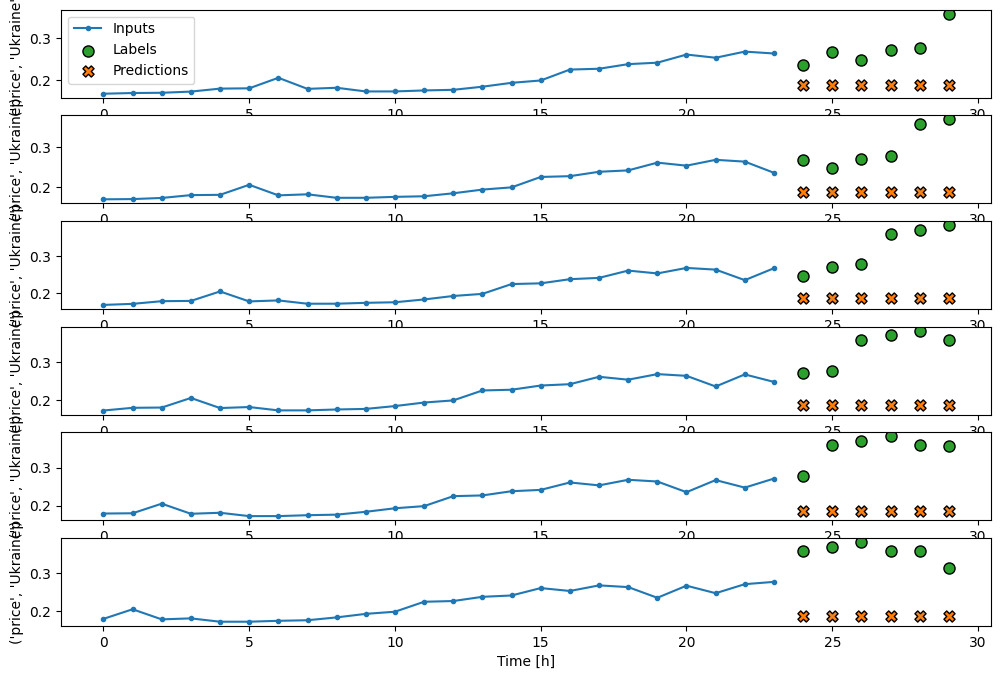

In [105]:
val_performance = {}
performance = {}

w.test

# val_performance['1'] = m.evaluate(w.val)
for i in range(6):

    label = label_columns[i]
    print(label)
    # performance['1'] = m.evaluate(w.test)
    w.plot(model, plot_col=label, max_subplots=6)


In [86]:
inputs, labels, weights = [], [], []
for x, y in w.test.take(1):
    inputs.append(x)
    labels.append(y)
    _, weights = m_arf.attention_layer(x, return_weights=True)
inputs = tf.concat(inputs, axis=0)
labels = tf.concat(labels, axis=0)
weights = tf.concat(weights, axis=0)
weights = tf.reduce_mean(weights, axis=0)
weights

<tf.Tensor: shape=(1, 75), dtype=float32, numpy=
array([[0.10384242, 0.692739  , 0.6376056 , 0.46793264, 0.2769388 ,
        0.58591276, 0.42932564, 0.4007569 , 0.919346  , 0.6096262 ,
        0.72184366, 0.46950683, 0.65400344, 0.39453   , 0.42625266,
        0.5967326 , 0.58795357, 0.60459346, 0.7591872 , 0.48518023,
        0.68258876, 0.39740747, 0.51888394, 0.4664705 , 0.3495219 ,
        0.64212406, 0.2853625 , 0.47432163, 0.65787506, 0.6561266 ,
        0.6065755 , 0.3532431 , 0.43037072, 0.3884227 , 0.41752097,
        0.45227158, 0.5128907 , 0.7032005 , 0.7410511 , 0.59401375,
        0.4592999 , 0.5385737 , 0.68145907, 0.8965785 , 0.39717886,
        0.4958964 , 0.43536124, 0.35916975, 0.24195929, 0.31656426,
        0.34228197, 0.20197447, 0.34400573, 0.5659847 , 0.46723065,
        0.29682487, 0.29924074, 0.5300885 , 0.3438664 , 0.46768692,
        0.5087917 , 0.24982391, 0.60976404, 0.57040143, 0.4989198 ,
        0.40807417, 0.6215977 , 0.5143183 , 0.2914587 , 0.42918307,

In [46]:
w.train_df.columns

MultiIndex([(                                 'price_trend',  'Brazil'),
            (                              'price_seasonal',  'Brazil'),
            (                              'price_residual',  'Brazil'),
            (                                 'price_trend',  'France'),
            (                              'price_seasonal',  'France'),
            (                              'price_residual',  'France'),
            (                                 'price_trend', 'Germany'),
            (                              'price_seasonal', 'Germany'),
            (                              'price_residual', 'Germany'),
            (                                 'price_trend',  'Global'),
            (                              'price_seasonal',  'Global'),
            (                              'price_residual',  'Global'),
            (                                 'price_trend', 'Hungary'),
            (                              'price_s

In [65]:
for weight, column in zip(weights[0], w.train_df.columns):
    print(weight.numpy(), column)

0.66841185 ('price_trend', 'Brazil')
0.51962435 ('price_seasonal', 'Brazil')
0.8328509 ('price_residual', 'Brazil')
0.515607 ('price_trend', 'France')
0.82618856 ('price_seasonal', 'France')
0.9735433 ('price_residual', 'France')
0.559095 ('price_trend', 'Germany')
0.4844928 ('price_seasonal', 'Germany')
0.631725 ('price_residual', 'Germany')
0.38050598 ('price_trend', 'Global')
0.79704 ('price_seasonal', 'Global')
0.66097504 ('price_residual', 'Global')
0.5991775 ('price_trend', 'Hungary')
0.63646716 ('price_seasonal', 'Hungary')
0.7667262 ('price_residual', 'Hungary')
0.48346606 ('price_trend', 'Ukraine')
0.67504454 ('price_seasonal', 'Ukraine')
0.70801604 ('price_residual', 'Ukraine')
0.7660224 ('AVG_TAVG', 'Brazil')
0.9659058 ('AVG_TAVG', 'France')
0.3781261 ('AVG_TAVG', 'Germany')
0.70125616 ('AVG_TAVG', 'Hungary')
0.8089385 ('AVG_TAVG', 'Ukraine')
0.37157333 ('Corn Price Futures', 'Global')
0.35687998 ('MAX_TMAX', 'Brazil')
0.57418287 ('MAX_TMAX', 'France')
0.65895987 ('MAX_TMAX'

In [69]:
np.save(gonem_directory / "inputs", inputs.numpy())
np.save(gonem_directory / "labels", labels.numpy())



In [ ]:
inputs = np.load(gonem_directory / "inputs.npy")
labels = np.load(gonem_directory / "labels.npy")

In [70]:
print(inputs.shape, labels.shape)

(7, 24, 75) (7, 6, 6)
